# Relation Extraction from Tables

This notebook demonstrates the full extraction and learning process for _relations_ in tables with a data set of transistor spec sheets, extracting (temperature label, min storage temperature) pairs. (Eventually, this tutorial will be updated to extract (part number, min storage temperature) pairs.

In [1]:
%load_ext autoreload
%autoreload 2

### Extraction

Use this option if you would like to unpickle a previously parsed corpus, (i.e., the corpus from the Entity Extraction notebook).

In [35]:
load_pickle = False
corpus_loaded = False

if load_pickle:
    try:
        import cPickle
        with open("data/hardware/hardware_corpus.pkl","r") as pkl:
            %time corpus = cPickle.load(pkl)
        corpus_loaded = True
        print "Corpus has been loaded."
    except:
        print "Corpus could not be loaded."
        print "Corpus will be parsed instead..."
if not corpus_loaded:
    from snorkel.parser import CorpusParser
    from snorkel.parser import HTMLParser
    from snorkel.parser import TableParser

    html_parser = HTMLParser(path='data/hardware/hardware_html/')
    table_parser = TableParser()

    cp = CorpusParser(html_parser, table_parser, max_docs=15)
    %time corpus = cp.parse_corpus(name='Hardware Corpus')
    print "Corpus has been parsed."

CPU times: user 7.81 s, sys: 630 ms, total: 8.44 s
Wall time: 15.1 s
Corpus has been parsed.


We now create two EntityExtractor objects, one for each component in the relation.

In [36]:
from snorkel.candidates import TableNgrams, EntityExtractor, RelationExtractor
from snorkel.matchers import RegexMatchEach, DictionaryMatch, RangeMatcher
from load_dictionaries import load_hardware_dictionary

# Select a CandidateSpace
table_ngrams = TableNgrams(n_max=2)

# Entity Extractor 1: Part numbers
parts = load_hardware_dictionary()
print "Loaded %s part numbers." % len(parts)

# NOTE: this will not catch items in ranges (e.g., BC546-BC548) or lists (e.g., BC546/547/548)
part_matcher = DictionaryMatch(d=parts, longest_match_only=False)
part_extractor = EntityExtractor(table_ngrams, part_matcher)

# Entity Extractor 2: Temperatures (min storage temperature)
# temp_matcher = RangeMatcher(low=140,high=160)
temp_matcher = RegexMatchEach(rgx=r'1[3-7][05]', attrib='words')
temp_extractor = EntityExtractor(table_ngrams, temp_matcher)

# Relation Extractor:
relation_extractor = RelationExtractor(part_extractor, temp_extractor)

Loaded 179 part numbers.


In [31]:
from snorkel.candidates import TableNgrams
from snorkel.matchers import NumberMatcher, RangeMatcher

# Define a candidate space
ngrams = TableNgrams(n_max=2)

# Define a matcher
# number_matcher = RangeMatcher(low=-70,high=-50)
temp_matcher = RegexMatchEach(rgx=r'1[3-7][05]', attrib='words')
from snorkel.candidates import EntityExtractor
ce = EntityExtractor(ngrams, temp_matcher)
%time candidates = ce.extract(corpus.get_tables(), name='all')
for cand in candidates[:10]: 
    print cand
print "%s candidates extracted" % len(candidates)

CPU times: user 591 ms, sys: 21 ms, total: 612 ms
Wall time: 610 ms
Span("150", context=None, chars=[0,2], words=[0,0])
Span("150", context=None, chars=[0,2], words=[0,0])
Span("150", context=None, chars=[0,2], words=[0,0])
Span("150", context=None, chars=[0,2], words=[0,0])
Span("150", context=None, chars=[0,2], words=[0,0])
Span("150", context=None, chars=[4,6], words=[2,2])
Span("150", context=None, chars=[0,2], words=[0,0])
Span("150", context=None, chars=[7,9], words=[3,3])
Span("150", context=None, chars=[0,2], words=[0,0])
Span("150", context=None, chars=[0,2], words=[0,0])
22 candidates extracted


In [32]:
candidates[0].context

Phrase('0', 5, 0, 2, u'150')

In [33]:
temp_matcher._f(candidates[0])

True

In [34]:
candidates[0].get_attrib_tokens('words')

[u'150']

In [27]:
all([])

True

In [30]:
import re
print re.match(r'1[3-7][05]', "")

None


In [37]:
# %time candidates = temp_extractor.extract(corpus.get_tables(), name='all')
%time candidates = relation_extractor.extract(corpus.get_tables(), name='all')

for cand in candidates[:10]: 
    print cand
print "%s part numbers extracted" % len(candidates)

CPU times: user 1.92 s, sys: 19 ms, total: 1.94 s
Wall time: 1.94 s
SpanPair(Span("BC546", context=None, chars=[122,126], words=[24,24]), Span("150", context=None, chars=[0,2], words=[0,0]))
SpanPair(Span("BC546", context=None, chars=[122,126], words=[24,24]), Span("150", context=None, chars=[0,2], words=[0,0]))
SpanPair(Span("BC546", context=None, chars=[122,126], words=[24,24]), Span("150", context=None, chars=[0,2], words=[0,0]))
SpanPair(Span("BC547", context=None, chars=[0,4], words=[0,0]), Span("150", context=None, chars=[0,2], words=[0,0]))
SpanPair(Span("BC547", context=None, chars=[0,4], words=[0,0]), Span("150", context=None, chars=[0,2], words=[0,0]))
SpanPair(Span("BC547", context=None, chars=[0,4], words=[0,0]), Span("150", context=None, chars=[0,2], words=[0,0]))
SpanPair(Span("BC548", context=None, chars=[0,4], words=[0,0]), Span("150", context=None, chars=[0,2], words=[0,0]))
SpanPair(Span("BC548", context=None, chars=[0,4], words=[0,0]), Span("150", context=None, chars

In [44]:
from utils import collect_hardware_relation_gold
filename = 'data/hardware/gold_all.csv'
gt_dict = collect_hardware_relation_gold(filename, 'stg_temp_max', candidates)
print "%s out of %s candidates have gold labels" % (len(gt_dict),len(candidates))
print "%s out of %s labeled candidates have positive label" \
        % (gt_dict.values().count(1), len(gt_dict))

179 gold annotations available
99 out of 99 candidates have gold labels
99 out of 99 labeled candidates have positive label


In [7]:
from snorkel.features import TableNgramPairFeaturizer
featurizer = TableNgramPairFeaturizer()
featurizer.fit_transform(candidates)
for f in featurizer.get_features_by_candidate(candidates[0])[:10]: print f

e0_DDLIB_WORD_SEQ_[BC547]
e0_DDLIB_LEMMA_SEQ_[bc547]
e0_DDLIB_POS_SEQ_[NN]
e0_DDLIB_DEP_SEQ_[ROOT]
e0_DDLIB_W_LEFT_1_[bc547]
e0_DDLIB_W_LEFT_POS_1_[NN]
e0_DDLIB_NUM_WORDS_1
e0_TABLE_ROW_NUM_[0]
e0_TABLE_COL_NUM_[0]
e0_TABLE_HTML_TAG_td


In [45]:
from snorkel.snorkel import DDLiteModel
DDL = DDLiteModel(candidates, featurizer.fit_transform(candidates), gt_dict)

DDL.set_holdout(idxs=range(int(len(gt_dict)*.5)), validation_frac=0.5)
print "%s training data" % len(DDL.gt.get_labeled_ground_truth('training')[0])
print "%s test data" % len(DDL.gt.get_labeled_ground_truth('test')[0])
print "%s validation data" % len(DDL.gt.get_labeled_ground_truth('validation')[0])

50 training data
25 test data
24 validation data


In [49]:
# Part number LFs
# TODO

# Temperature LFs
def LF_to_range(m):
    return 1 if 'to' in m.span1.pre_window('words') else 0
def LF_tilde_range(m):
    return 1 if '~' in m.span1.pre_window('words') else 0
def LF_storage(m):
    return 1 if 'storage' in m.span1.aligned_ngrams('words') else -1
def LF_tstg(m):
    return 1 if 'tstg' in m.span1.aligned_ngrams('words') else -1
def LF_tj(m):
    return 1 if 'tj' in m.span1.aligned_ngrams('words') else -1
def LF_temperature(m):
    return 1 if 'temperature' in m.span1.aligned_ngrams('words') else -1
def LF_celsius(m):
    return 1 if 'c' in m.span1.aligned_ngrams('words') else 0
def LF_max(m):
    return 1 if 'max' in m.span1.aligned_ngrams('lemmas') else 0
def LF_min(m):
    return 1 if 'min' in m.span1.aligned_ngrams('lemmas') else 0

# Combined LFs
def LF_same_row(m):
    return 1 if m.span0.context.row_num == m.span1.context.row_num else 0
def LF_same_col(m):
    return 1 if m.span0.context.col_num == m.span1.context.col_num else 0

# NOTE: don't forget to add LF name to LFs below

In [50]:
LFs = [LF_to_range, LF_tilde_range, LF_storage, LF_tstg, LF_tj, LF_temperature, 
       LF_max, LF_min, LF_same_row, LF_same_col]
DDL.apply_lfs(LFs, clear=True)

In [51]:
print DDL.lf_names
DDL.print_lf_stats()

['LF_to_range', 'LF_tilde_range', 'LF_storage', 'LF_tstg', 'LF_tj', 'LF_temperature', 'LF_max', 'LF_min', 'LF_same_row', 'LF_same_col']
LF stats on training set
Coverage:	100.000%
Overlap:	100.000%
Conflict:	70.000%


In [52]:
DDL.lowest_coverage_lfs(n=10)

Labeling function,Candidate coverage
LF_max,0.00%
LF_tilde_range,0.00%
LF_min,0.00%
LF_to_range,0.00%
LF_storage,100.00%
LF_same_col,100.00%
LF_tj,100.00%
LF_temperature,100.00%
LF_tstg,100.00%
LF_same_row,100.00%


Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.549911
	Learning epoch = 250	Gradient mag. = 2.362587
Final gradient magnitude for rate=0.01, mu=1e-07: 1.658
Running in False mode...
Begin training for rate=0.01, mu=1e-09
	Learning epoch = 0	Gradient mag. = 0.262364
	Learning epoch = 250	Gradient mag. = 0.275522
	Learning epoch = 500	Gradient mag. = 0.274873
	Learning epoch = 750	Gradient mag. = 0.274225
	Learning epoch = 1000	Gradient mag. = 0.273579
	Learning epoch = 1250	Gradient mag. = 0.272935
	Learning epoch = 1500	Gradient mag. = 0.272292
	Learning epoch = 1750	Gradient mag. = 0.271651
	Learning epoch = 2000	Gradient mag. = 0.271012
	Learning epoch = 2250	Gradient mag. = 0.270374
	Learning epoch = 2500	Gradient mag. = 0.269738
	Learning epoch = 2750	Gradient mag. = 0.269103
Final gradient magnitude for rate=0.01, mu=1e-09: 0.268
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.262364
	Learning epoch = 250	Gradient mag. = 0

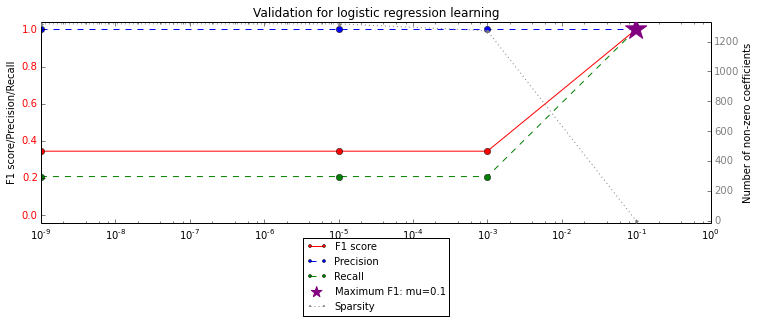

CPU times: user 6.14 s, sys: 42.8 ms, total: 6.18 s
Wall time: 6.31 s


<snorkel.snorkel.ModelLog instance at 0x116ca4f80>

In [53]:
import matplotlib
import numpy as np
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,4)
mu_seq = np.ravel([1e-9, 1e-5, 1e-3, 1e-1])
lf_opts = {'sample': False, 'verbose': True}
model_opts = {'sample': False, 'n_iter': 3000, 'alpha': 0.5, 'mu': mu_seq, 'bias': False, 'verbose': True}
%time DDL.train_model(method='lr', lf_opts=lf_opts, model_opts=model_opts)